In [1]:
# setup
import numpy as np
import scipy
import scipy.spatial
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize
nr_sets = 5


In [2]:
def simplices2poly(simplices):
    poly = [int(simplices[0][0])]
    edges = set([(i, j) for i, j in simplices])
    while len(edges):
        #print(poly, edges)
        next_edge = None
        next_val = None
        for edge in edges:
            i, j = edge
            if i == poly[-1]:
                next_edge = (i, j)
                next_val = j
                break
            if j == poly[-1]:
                next_edge = (i, j)
                next_val = i
                break
        edges.remove(next_edge)
        poly.append(next_val)
    return poly

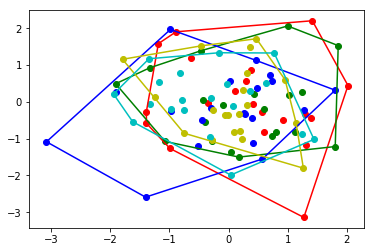

In [170]:
colors = 'rgbyc'
# show C_i
C = [None] * nr_sets
nr_point_dim = 2
X = np.zeros((nr_sets, nr_point_dim, nr_point_dim), dtype=np.float32)
for idx_set in range(nr_sets):
    points = np.random.randn(20, nr_point_dim)
    hull = scipy.spatial.ConvexHull(points)
    plt.scatter(points[:, 0], points[:, 1], c=colors[idx_set])
    poly = simplices2poly(hull.simplices)
    plt.plot(points[poly, 0], points[poly, 1], c=colors[idx_set])
    C[idx_set] = (points[poly], points)
    X[idx_set] = np.eye(nr_point_dim)+np.random.randn(nr_point_dim, nr_point_dim)*5

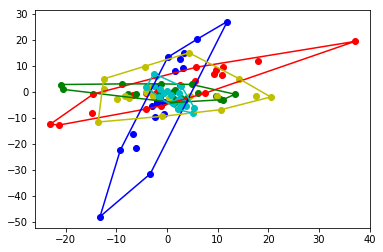

In [171]:
# show D_i
D = [None]*nr_sets
for idx_set in range(nr_sets):
    points_poly, points = C[idx_set]
    points_poly = np.einsum('ij,nj->ni', X[idx_set].T, points_poly)
    points = np.einsum('ij,nj->ni', X[idx_set].T, points)
    D[idx_set] = (points_poly, points)
    plt.scatter(points[:, 0], points[:, 1], c=colors[idx_set])
    plt.plot(points_poly[:, 0], points_poly[:, 1], c=colors[idx_set])

In [201]:
y = np.random.randn(nr_point_dim) * 50
y

array([74.23618015, 56.53192839])

# primal coordinate descent

\begin{equation}
\min_{w \in R^p} \; \frac{1}{2} \|y - Xw\|_2^2 + 
\sum_{i=1}^d h_i(w_i), 
\end{equation}
\begin{equation}
w_i^{(k)} = \arg \min_{w_i \in R^{p_i}} \; \frac{1}{2} \bigg\| y - \sum_{j<i}
X_j w_j^{(k)} - \sum_{j>i} X_j w_j^{(k-1)} - X_iw_i \bigg\|_2^2 + h_i(w_i),
\quad i=1,\ldots,d, 
\end{equation}

In [202]:
def hi(w_i, d_i):
    points_poly, _ = d_i
    return np.max(points_poly@w_i)

def wi_criterion(w_i, w_k_prev, w_k_next, i):
    val_hi = hi(w_i, D[i])
    err = y - np.einsum('nij,nj->i', X[i+1:], w_k_prev[i+1:]) - np.einsum('nij,nj->i', X[:i], w_k_next[:i]) - X[i]@w_i
    # print(w_i, val_hi, np.sum(err*err))
    return 0.5 * np.sum(err*err) + val_hi

In [203]:
def f(w_i, w_k_prev, w_k_next, i):
    return wi_criterion(w_i, w_k_prev, w_k_next, i) + sum([hi(w_k_next[j], D[j]) for j in range(i)]) + sum([hi(w_k_prev[j], D[j]) for j in range(i+1, nr_sets)])

In [204]:
import cvxpy as cp
def optimize_wi(w_k_prev, w_k_next, i):
    residual =  y - np.einsum('nij,nj->i', X[i+1:], w_k_prev[i+1:]) - np.einsum('nij,nj->i', X[:i], w_k_next[:i])
    w_i = cp.Variable(nr_point_dim)
    objective = cp.Minimize(cp.sum_squares(residual-X[i]@w_i)/2+cp.max(D[i][0]@w_i))
    prob = cp.Problem(objective)
    result = prob.solve(verbose=False, solver='SCS')
    return w_i.value
w_prev = np.zeros((nr_sets, nr_point_dim))
w_next = np.zeros((nr_sets, nr_point_dim))
for i in range(5):
    print(optimize_wi(w_prev, w_next, i))

WARN: aa_init returned NULL, no acceleration applied.
[-16.91600198  28.29121217]
WARN: aa_init returned NULL, no acceleration applied.
[-11.53978125 -19.36578284]
WARN: aa_init returned NULL, no acceleration applied.
[-22.62830716  11.38085926]
WARN: aa_init returned NULL, no acceleration applied.
[ 5.69285328 -6.2174778 ]
WARN: aa_init returned NULL, no acceleration applied.
[-33.74232085  -5.2445173 ]


In [205]:
nr_outer_iter = 20
w_primal = np.zeros((nr_outer_iter+1, nr_sets, nr_point_dim))
for idx_outer_iter in range(nr_outer_iter):
    for idx_inner_iter in range(nr_sets):
        w_primal[idx_outer_iter+1, idx_inner_iter] = optimize_wi(w_primal[idx_outer_iter], w_primal[idx_outer_iter+1], idx_inner_iter)
        print(idx_outer_iter, idx_inner_iter, f(w_primal[idx_outer_iter+1, idx_inner_iter], w_primal[idx_outer_iter], w_primal[idx_outer_iter+1], idx_inner_iter))

WARN: aa_init returned NULL, no acceleration applied.
0 0 226.4747047403631
WARN: aa_init returned NULL, no acceleration applied.
0 1 226.41798801499277
WARN: aa_init returned NULL, no acceleration applied.
0 2 225.8414948651434
WARN: aa_init returned NULL, no acceleration applied.
0 3 225.8414952123765
WARN: aa_init returned NULL, no acceleration applied.
0 4 225.8414953527168
WARN: aa_init returned NULL, no acceleration applied.
1 0 224.8403972327019
WARN: aa_init returned NULL, no acceleration applied.
1 1 224.78025114358425
WARN: aa_init returned NULL, no acceleration applied.
1 2 224.20371571644216
WARN: aa_init returned NULL, no acceleration applied.
1 3 224.2037157154174
WARN: aa_init returned NULL, no acceleration applied.
1 4 224.20371571536248
WARN: aa_init returned NULL, no acceleration applied.
2 0 223.20262845326693
WARN: aa_init returned NULL, no acceleration applied.
2 1 223.1416029231604
WARN: aa_init returned NULL, no acceleration applied.
2 2 222.56494070574993
WARN: 

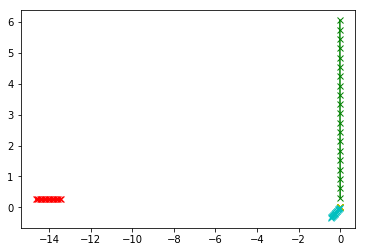

In [199]:
for i in range(nr_sets):
    plt.plot(w_primal[1:, i,0], w_primal[1:, i, 1], c=colors[i], marker='x')

# Dual dykstra
\begin{align*}
u_0^{(k)} &= u_d^{(k-1)}, \\
u_i^{(k)} &= P_{C_i} (u_{i-1}^{(k)} + z_i^{(k-1)}),\\
z_i^{(k)} &= u_{i-1}^{(k)} + z_i^{(k-1)} - u_i^{(k)},
\end{align*}

In [200]:
def PC(point, c_i):
    points_hull, _ = c_i
    projection = cp.Variable(nr_point_dim)
    objective = cp.Minimize(cp.sum_squares(point-projection))
    centroid = points_hull.mean(axis=0)
    centroid = np.array([centroid[0], centroid[1], 1])
    
    constraints = []
    for i in range(len(points_hull)-1):
        p1 = points_hull[i]
        p2 = points_hull[i+1]
        line = scipy.linalg.null_space([[p1[0],p1[1],1], [p2[0],p2[1],1]])[:,0]
        # print(line, centroid)
        if line@centroid > 0:
            constraints.append(projection@line[:2]+line[2]>=0)
        else:
            constraints.append(projection@line[:2]+line[2]<=0)
    prob = cp.Problem(objective, constraints)
    result = prob.solve(verbose=False, solver='SCS')
    return projection.value

projection = PC(y, C[0])
print(projection)
print(y-X[0]@optimize_wi(w_prev, w_next, 0))

WARN: aa_init returned NULL, no acceleration applied.
[-1.18952669  0.30324805]
WARN: aa_init returned NULL, no acceleration applied.
[-0.89289131  1.91483774]


In [193]:
u_dual = np.zeros((nr_outer_iter+1, nr_sets+1, nr_point_dim))
z_dual = np.zeros((nr_outer_iter+1, nr_sets+1, nr_point_dim))
u_dual[0, nr_sets] = y

for idx_outer_iter in range(1, nr_outer_iter+1):
    u_dual[idx_outer_iter, 0] = u_dual[idx_outer_iter-1, nr_sets] 
    for idx_inner_iter in range(1, nr_sets+1):
        u = u_dual[idx_outer_iter, idx_inner_iter-1]
        z = z_dual[idx_outer_iter-1, idx_inner_iter]
        s = u + z
        proj = PC(s, C[idx_inner_iter-1])
        u_dual[idx_outer_iter, idx_inner_iter] = proj
        z_dual[idx_outer_iter, idx_inner_iter] = s - proj
        print(u, z, s, proj, np.linalg.inv(X[idx_inner_iter-1])@(s - proj))


WARN: aa_init returned NULL, no acceleration applied.
[22.45882993  1.94605363] [0. 0.] [22.45882993  1.94605363] [2.02296653 0.44159882] [-2.55515326  5.97733456]
WARN: aa_init returned NULL, no acceleration applied.
[2.02296653 0.44159882] [0. 0.] [2.02296653 0.44159882] [1.83762766 0.44501291] [-0.02067265 -0.08924972]
WARN: aa_init returned NULL, no acceleration applied.
[1.83762766 0.44501291] [0. 0.] [1.83762766 0.44501291] [1.77190716 0.33628627] [-0.01393222  0.01161853]
WARN: aa_init returned NULL, no acceleration applied.
[1.77190716 0.33628627] [0. 0.] [1.77190716 0.33628627] [1.01844186 0.21647209] [ 0.01913911 -0.08607634]
WARN: aa_init returned NULL, no acceleration applied.
[1.01844186 0.21647209] [0. 0.] [1.01844186 0.21647209] [1.01844182 0.21647197] [-5.67068395e-08 -2.95643650e-08]
WARN: aa_init returned NULL, no acceleration applied.
[1.01844182 0.21647197] [20.43586339  1.50445481] [21.45430522  1.72092679] [2.02299528 0.44181062] [-2.40540462  5.66189558]
WARN: aa

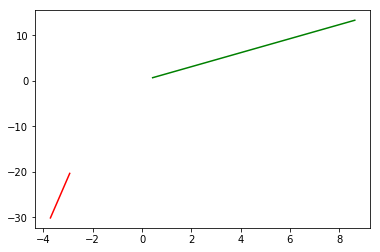

In [146]:
for i in range(nr_sets):
    w = np.einsum('ij,nj->ni',np.linalg.inv(X[i]),z_dual[:,i+1])
    plt.plot(w[1:,0], w[1:,1], c=colors[i])

In [136]:
z_dual

array([[[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 4.74803969e+01,  2.95600945e+01],
        [ 7.57297539e-01,  5.46266759e-01],
        [-1.96007293e-07, -1.09349126e-07],
        [-7.52202252e-05,  5.50322510e-06],
        [-1.18701803e-05,  5.37665438e-05]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 4.67231638e+01,  2.90137493e+01],
        [ 1.51452167e+00,  1.09250688e+00],
        [-1.96076219e-07, -1.09298977e-07],
        [-7.52274876e-05,  5.50268401e-06],
        [-1.18616237e-05,  5.37451071e-05]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 4.59659174e+01,  2.84674905e+01],
        [ 2.27181861e+00,  1.63875078e+00],
        [-1.96031420e-07, -1.09297945e-07],
        [-7.52133275e-05, 